In [62]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50 
#,NASNetLarge
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import warnings
warnings.filterwarnings("ignore")

#from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam ,RMSprop
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16

In [63]:
image_width, image_height = 224,224

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.2,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(
                    "../input/skin-cencer-dataset-images/train",
                    batch_size=128,
                    class_mode='categorical',
                    shuffle=True,
                    target_size=(image_width, image_height)
)     

test_generator =  test_datagen.flow_from_directory(
                    "../input/skin-cencer-dataset-images/test",
                    batch_size=128,
                    class_mode='categorical',
                    shuffle=True,
                    target_size=(image_width, image_height)
)


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [64]:
train_steps = train_generator.n // train_generator.batch_size

print(train_steps)

20


In [65]:
test_steps = test_generator.n // test_generator.batch_size

print(test_steps)

5


In [66]:
#rs = ResNet50(weights='imagenet', include_top=True, input_shape=(image_width, image_height, 3))

In [67]:
rs = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=(image_width, image_height, 3),
                 pooling='avg',
                 classes=2)

In [68]:
for layers in (rs.layers):
    layers.trainable = False

In [69]:
rs.layers

In [70]:
model = Sequential()

# Add the ResNet50 convolutional base model
model.add(rs)

# Add new layers
model.add(Flatten())
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096 , activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2)                 23591810  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              12288     
_________________________________________________________________
dropout_9 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_10 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 4096)             

In [71]:
lr = 1e-6
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [72]:
mcp = ModelCheckpoint('modelResNe.h5', verbose=1)

In [73]:
es = EarlyStopping(patience=2,verbose=1)

In [74]:
history = model.fit(train_generator,steps_per_epoch=train_steps,epochs=30,validation_data=test_generator,validation_steps=test_steps,verbose=1,callbacks=[mcp,es])

Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4735 
Epoch 00001: saving model to modelResNe.h5
20/20 [==============================] - 290s 14s/step - loss: 0.6936 - accuracy: 0.4735 - val_loss: 0.6930 - val_accuracy: 0.5453
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.6925 - accuracy: 0.5209 
Epoch 00002: saving model to modelResNe.h5
20/20 [==============================] - 290s 15s/step - loss: 0.6925 - accuracy: 0.5209 - val_loss: 0.6925 - val_accuracy: 0.5406
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5413 
Epoch 00003: saving model to modelResNe.h5
20/20 [==============================] - 289s 14s/step - loss: 0.6920 - accuracy: 0.5413 - val_loss: 0.6918 - val_accuracy: 0.5516
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5472 
Epoch 00004: saving model to modelResNe.h5
20/20 [==============================] - 286s 14s/step 

In [75]:
model.evaluate(test_generator, verbose=1, steps=test_steps)

5/5 [==============================] - 45s 9s/step - loss: 0.6895 - accuracy: 0.5453


[0.6895340085029602, 0.5453125238418579]

Text(0.5, 1.0, 'Training and validation loss')

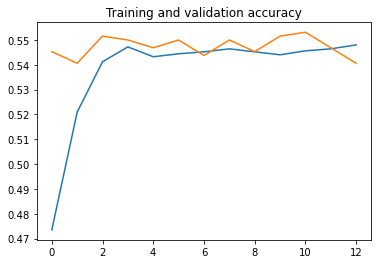

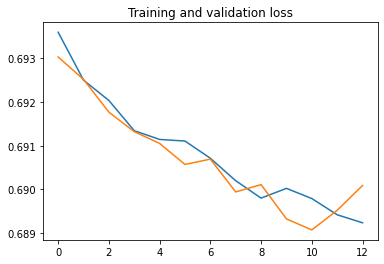

In [76]:
import matplotlib.pyplot as plt

accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy))

plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [77]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

In [78]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

image_width, image_height = 224,224

img = image.load_img('../input/skin-cencer-dataset-images/data/train/benign/1002.jpg', target_size=(image_width, image_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img/= 255.
model = load_model('modelResNe.h5')
result = model.predict(img)
train_generator.class_indices
if result[0][0] == 0:
    prediction = 'Malignant'
else:
    prediction = 'Benign'
print(prediction)

Benign


In [79]:
prediction = model.predict_classes(img)
prediction

array([0])

In [80]:
model.save('modelResNe.h5')

In [85]:
vvg = VGG16(input_shape=(224,224, 3), include_top=False,weights = 'imagenet')

In [86]:
vvg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [88]:
for layers in (vvg.layers):
    layers.trainable = False

In [90]:
model2 = Sequential()

# Add the vvg convolutional base model
model2.add(vvg)

# Add new layers
model2.add(Flatten())
model2.add(Dense(4096 , activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4096 , activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 4096)              102764544 
_________________________________________________________________
dropout_12 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_13 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 4096)             

In [ ]:
#z = layers.Flatten()(pretrained_model.output)
 
#z  = layers.Dense(4096 , activation='relu')(z)
#z  = layers.Dense(4096 , activation='relu')(z)
 
   
#z = layers.Dense(2, activation='softmax')(z)

In [ ]:
#model2 = Model(vvg.input, z)

In [ ]:
#model2.summary()

In [91]:
lr = 1e-4
model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [92]:
mcp2 = ModelCheckpoint('modelVVG.h5', verbose=1)

In [93]:
es2 = EarlyStopping(patience=2,verbose=1)

In [ ]:
#history = model.fit(train_generator,epochs=10,batch_size = 128)


In [ ]:
history = model2.fit(train_generator,steps_per_epoch=train_steps,epochs=30,validation_data=test_generator,validation_steps=test_steps,verbose=1,callbacks=[mcp2,es2])

Epoch 1/30
10/20 [==============>...............] - ETA: 5:46 - loss: 1.4358 - accuracy: 0.5375

In [ ]:
model2.evaluate(test_generator, verbose=1, steps=test_steps)

In [ ]:
import matplotlib.pyplot as plt

accuracy      = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(accuracy))

plt.plot(epochs, accuracy)
plt.plot(epochs, val_accuracy)
plt.title('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

image_width, image_height = 224,224

img = image.load_img('../input/skin-cencer-dataset-images/test/malignant/1026.jpg', target_size=(image_width, image_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)
img/= 255.
model = load_model('modelVVG.h5')
result = model.predict(img)
train_generator.class_indices
if result[0][0] == 0:
    prediction = 'Malignant'
else:
    prediction = 'Benign'
print(prediction)

In [ ]:
model.save('modelVVG.h5')